# 13 Aprile 2022: analisi dati completa per presentazione lavoro

In [5]:

import tempfile
import sys
import os

import ROOT

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from uncertainties import ufloat, umath

from ROOT import TH1D, TF1, TGraphErrors, TCanvas



In [6]:
%jsroot on
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
ROOT.gInterpreter.AddIncludePath('/usr/local/include')
ROOT.gSystem.Load('/usr/local/lib/libErrorAnalysis')
ROOT.gSystem.Load('/usr/local/lib/libLabTools')


1

In [9]:
ROOT.gInterpreter.ProcessLine('''#include<LabPlot.h>
#include<LabStat.h>''')

ROOT.set_atlas_style(30)

Applying ATLAS style settings


## Analogico: analisi dati finale

Problemi: incompatibilità con il valore teorico di $v_s$, osservare che per questi dati non abbiamo valutato la media ma solo il valore del primo fronte dell'onda, potrebbe essere sbagliato (anche considerato che utilizzando invece i dati della presa dati digitale otteniamo forse un valore più vicino alla teoria?)


### Fit: quale funzione vogliamo utilizzare?

Abbiamo effettuato il fit considerando una funzione lineare, per cui (ipotizzando che ricevitore ed emettitore siano in asse abbiamo che $d = v_s\cdot t.$ Dobbiamo però considerare la possibilità di un errore sistematico di offset sulla distanza $d$, quindi rendendo la funzione di fit simile a $d=d_\text{offset}+v_st.$

Però abbiamo che potremmo non avere in perfetto asse i due strumenti e quindi la necessità di avere un offset laterale, per cui la distanza che in realtà compie è $d_\text{true}=\sqrt{d_\text{meas} + \delta_\text{lat}}.$ Così facendo abbiamo che però non funziona il fit per il secondo set di dati, mentre con il primo abbiamo un miglior rendimento (Prob($\chi^2$) > 70%). Inoltre in tale modo i rusultati non vengono compatibili.

Funzione con approssimazione ad ordime maggiore sarebbe quindi $$d=\sqrt{v_s^2t^2 + \text{(offset)}^2 -\delta^2 + 2\text{(offset)}v_st},$$ oppure $$t = \frac{1}{v_s}\sqrt{d^2+\delta^2}+\frac{\text{offset}}{v_s}.$$

In [50]:

path_misc = '../misc'
path_data = '../dati'

analogic_files = ['uedge_analog_data_220329.txt',
                  'dedge_analog_data_220329.txt']

def get_t_range_error(range1, errPercent=0.0016, partitions=10.0):
    return range1 * errPercent * partitions / np.sqrt(3);

offset_tmp = 0.19; # offset di misura (initial guess)
diametro_spk = 0.05985; # 2*offset verticale (da aggiungere in quadratura)



In [81]:
def setup_data(filename, color, function = '[0]+[1]*x', name = 'analog_rise'):
    graph = TGraphErrors()
    graph.SetTitle(';Delay [ms];Distance [m]')
    fit = TF1(name, function)
    
    graph.SetLineColor(color)
    graph.SetMarkerColor(color)
    fit.SetLineColor(color)
    
    file = open(os.path.join(path_data, filename))
    lines = file.readlines()
    for idx, line in enumerate(lines):
        data = line.split()
        graph.SetPoint(idx, float(data[1]), float(data[0]))
        graph.SetPointError(idx, get_t_range_error(float(data[2])), 0.001/np.sqrt(3))
    
    return graph, fit
    

In [82]:
rise_analogic, f_rise_analogic = setup_data(analogic_files[0], ROOT.kBlack, name='analog_rise')
fall_analogic, f_fall_analogic = setup_data(analogic_files[1], ROOT.kRed, name='analog_fall')

 FCN=20.2347 FROM MIGRAD    STATUS=CONVERGED      24 CALLS          25 TOTAL
                     EDM=1.8174e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.46711e-01   4.27691e-04   4.20768e-07  -1.70771e-01
   2  p1           3.48060e-01   6.53774e-04   6.43190e-07   1.87025e-01
 FCN=1.20962 FROM MIGRAD    STATUS=CONVERGED      23 CALLS          24 TOTAL
                     EDM=1.06966e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.27950e-01   9.14809e-04   2.15053e-07   1.29252e-01
   2  p1           3.49868e-01   1.03231e-03   2.42675e-07   8.32408e-02


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


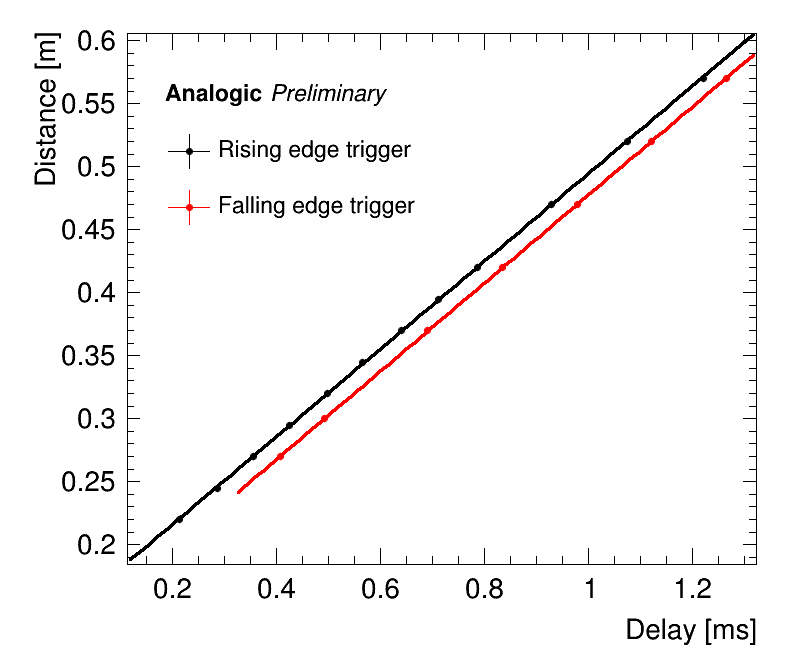

In [84]:
%jsroot off


c1 = TCanvas('c1', '', 800, 700)
l = ROOT.TLegend(0.2, 0.65, 0.5, 0.9)
l.SetFillColorAlpha(0, 0.75)
l.SetTextSize(25)
l.SetHeader('#bf{Analogic} #it{Preliminary}')


rise_analogic.Draw('ap')
rise_analogic.Fit('analog_rise')
fall_analogic.Draw('p')
fall_analogic.Fit('analog_fall')
l.AddEntry(rise_analogic, 'Rising edge trigger', 'LPE')
l.AddEntry(fall_analogic, 'Falling edge trigger', 'LPE')
l.Draw()
c1.Draw()

In [96]:
popt_rise_ag, poperr_rise_ag = f_rise_analogic.GetParameters(), f_rise_analogic.GetParErrors()
popt_fall_ag, poperr_fall_ag = f_fall_analogic.GetParameters(), f_fall_analogic.GetParErrors()



In [114]:
sspeed_ag_rise = ufloat(popt_rise_ag[1], poperr_rise_ag[1])
sspeed_ag_fall = ufloat(popt_fall_ag[1], poperr_fall_ag[1])

offset_ag_rise = ufloat(popt_rise_ag[0], poperr_rise_ag[0])
offset_ag_fall = ufloat(popt_fall_ag[0], poperr_fall_ag[0])

print('rise (analog):\t{:.3uS} m/s\t[offset: {:.3uS} m]'.format(sspeed_ag_rise*1000, offset_ag_rise))
print('fall (analog):\t{:.3uS} m/s\t[offset: {:.3uS} m]'.format(sspeed_ag_fall*1000, offset_ag_fall))

print(' * compatibilità sspeed_ag: {}'.format(ROOT.LabStat.compatible_nocorr(popt_rise_ag[1], poperr_rise_ag[1], popt_fall_ag[1], poperr_fall_ag[1])))
print(' * compatibilità offsets:   {}'.format(ROOT.LabStat.compatible_nocorr(popt_rise_ag[0], poperr_rise_ag[0], popt_fall_ag[0], poperr_fall_ag[0])))


sspeed_ag = ROOT.LabStat.getbestvalue(popt_rise_ag[1], poperr_rise_ag[1], popt_fall_ag[1], poperr_fall_ag[1])
sspeed_ag_err = ROOT.LabStat.getbestvalueerr(poperr_rise_ag[1], poperr_fall_ag[1])

print('rise+fall (analog):\t{:.3uS} m/s'.format(ufloat(sspeed_ag, sspeed_ag_err)*1000))








rise (analog):	348.060(654) m/s	[offset: 0.146711(428) m]
fall (analog):	349.87(1.03) m/s	[offset: 0.127950(915) m]
 * compatibilità sspeed_ag: COMPATIBILE
 * compatibilità offsets:   NON-COMPATIBILE: significativita' statistica  18.578002 σ
rise+fall (analog):	348.577(552) m/s


In [108]:
ROOT.LabStat.get_statsign(popt_rise_ag[1], poperr_rise_ag[1], popt_fall_ag[1], poperr_fall_ag[1])

"significativita' statistica  1.479216 σ"

In [109]:
c1.Print('../fig/plot_a220417.pdf')

Info in <TCanvas::Print>: pdf file ../fig/plot_a220417.pdf has been created


In [110]:
ROOT.gInterpreter.ProcessLine('''
#include<LabTools.h>
''')

0

In [111]:
ROOT.logs.print_stat(f_rise_analogic), ROOT.logs.print_stat(f_fall_analogic)

(None, None)


** CHI2 / NDF ( PROB. ) 20.2347 / 10 ( 0.0271097 )


** CHI2 / NDF ( PROB. ) 1.20962 / 5 ( 0.943952 )



## Digitale: analisi dati finale

In [118]:

digital_files = ["DATA_serial_25.txt",
                "DATA_serial_30.txt",
                "DATA_serial_32.txt",
                "DATA_serial_35.txt",
                "DATA_serial_37.txt",
                "DATA_serial_40.txt",
                "DATA_serial_45.txt",
                "DATA_serial_50.txt",
                "DATA_serial_52.txt",
                "DATA_serial_55.txt",
                "DATA_serial_57.txt",
                "DATA_serial_60.txt"]






In [137]:
def histo4plot(filename):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, figsize=(10, 2.5))
    fNdataread = 50
    timeRUN_onrise = np.zeros((2, fNdataread))
    timeRUN_onfall = np.zeros((2, fNdataread))
    
    file = open(os.path.join(path_misc, filename))
    
    for j in range(2):
        for i in range(50):
            data = file.readline()
            timeRUN_onrise[j][i] = float(data)
    
    for j in range(2):
        for i in range(50):
            data = file.readline()
            timeRUN_onfall[j][i] = float(data)
    
    ax1.hist(timeRUN_onfall[0], bins=20)
    ax2.hist(timeRUN_onfall[1], bins=20)
    ax3.hist(timeRUN_onrise[0], bins=20)
    ax4.hist(timeRUN_onrise[1], bins=20)

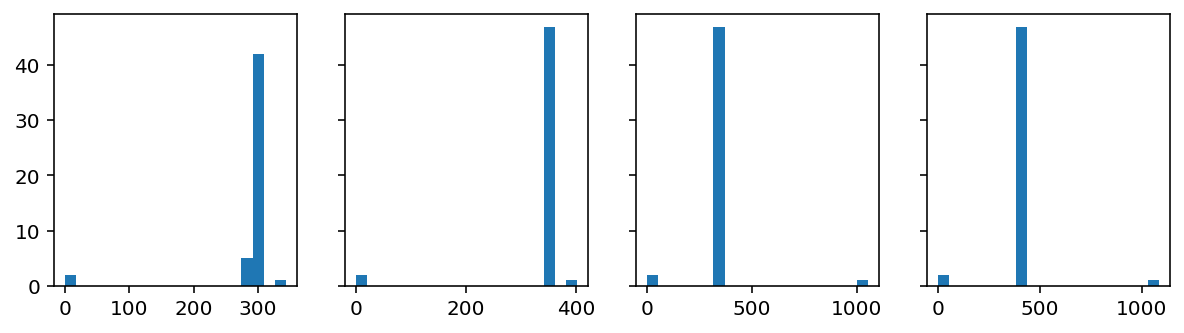

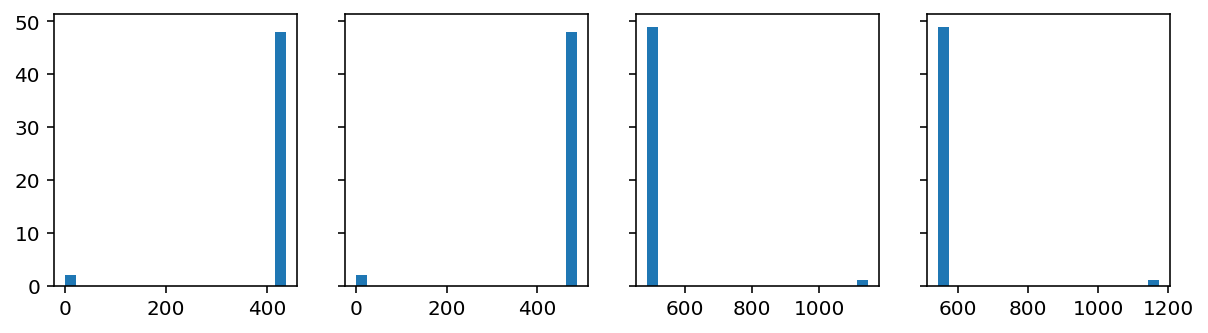

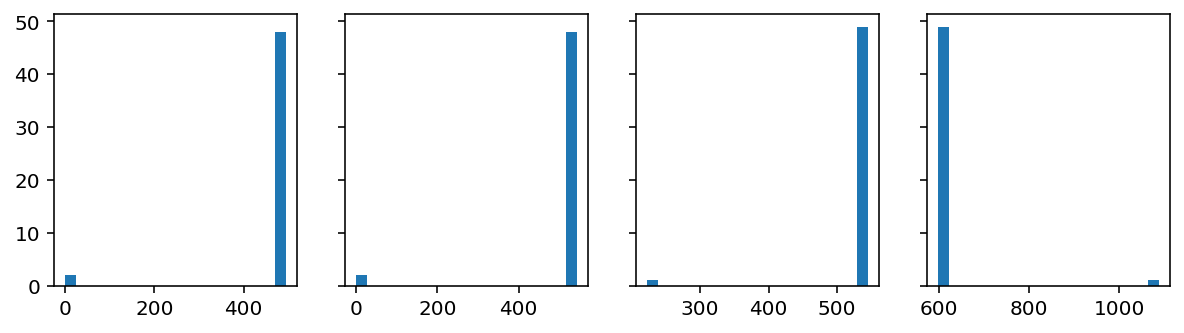

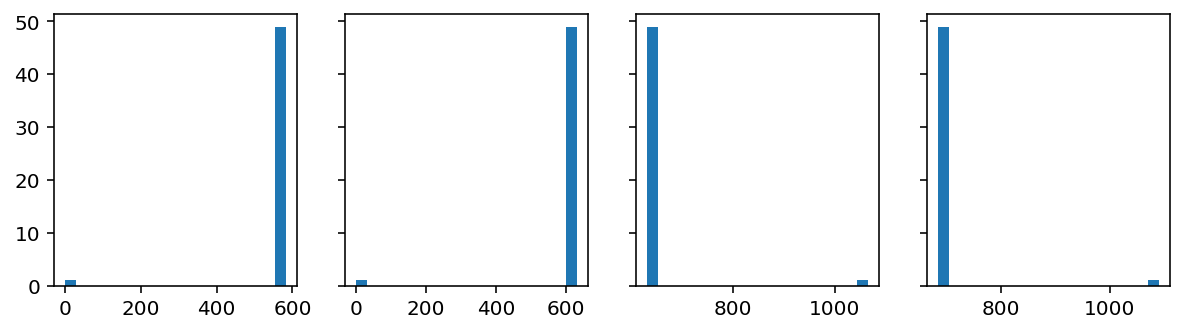

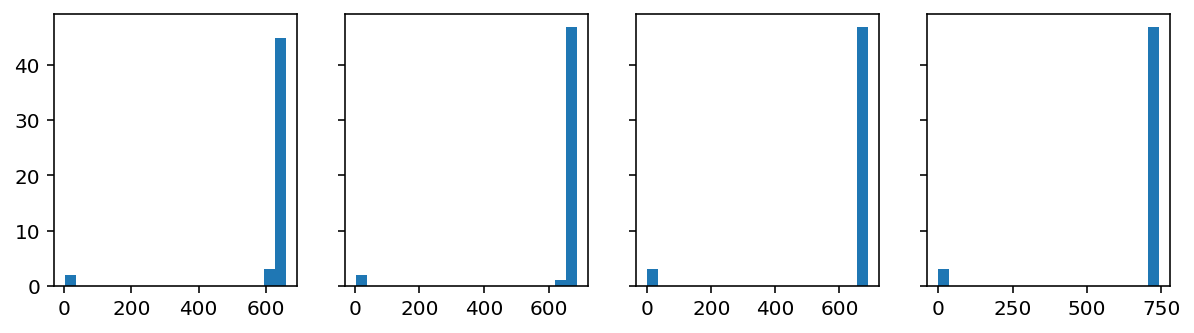

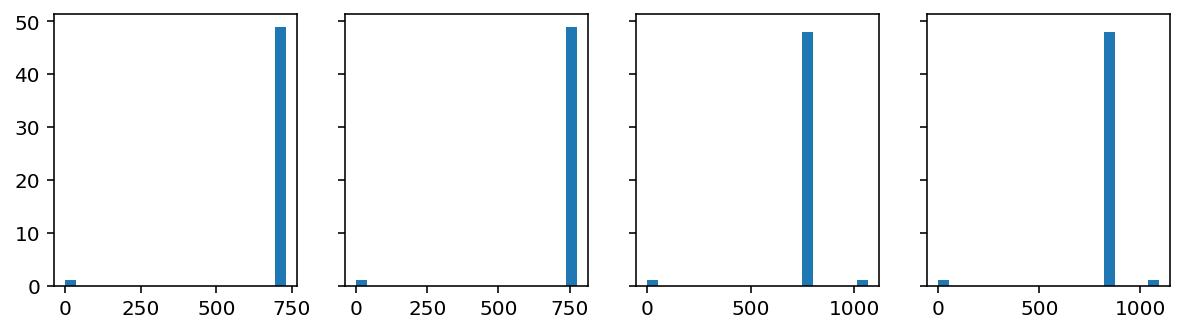

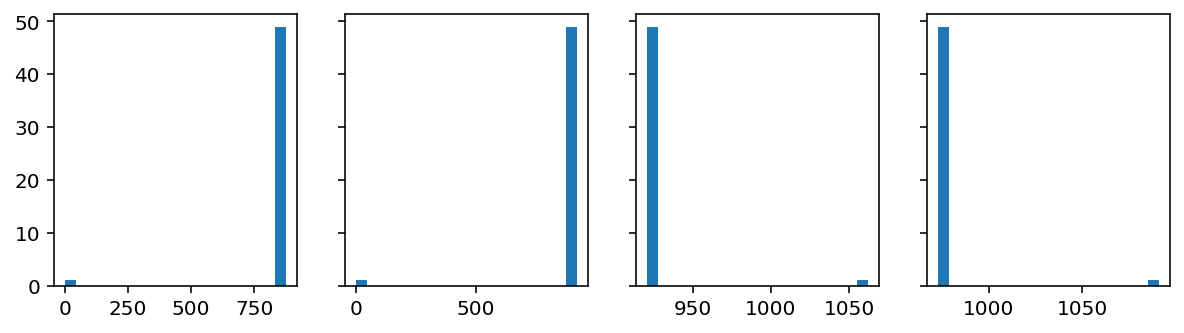

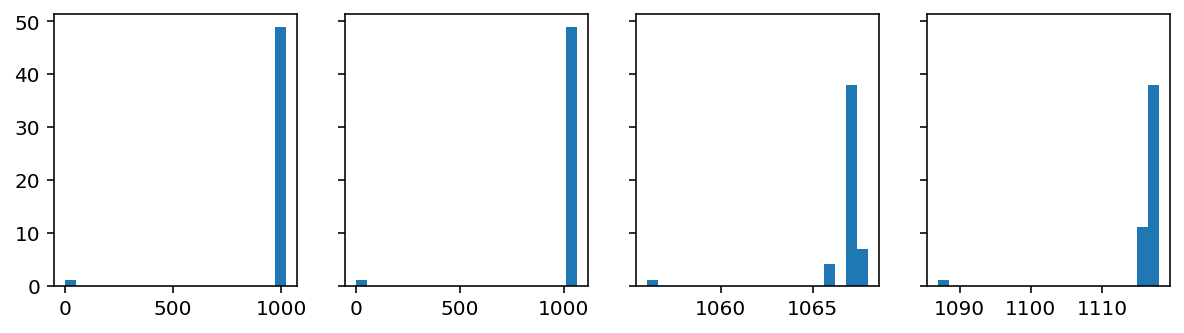

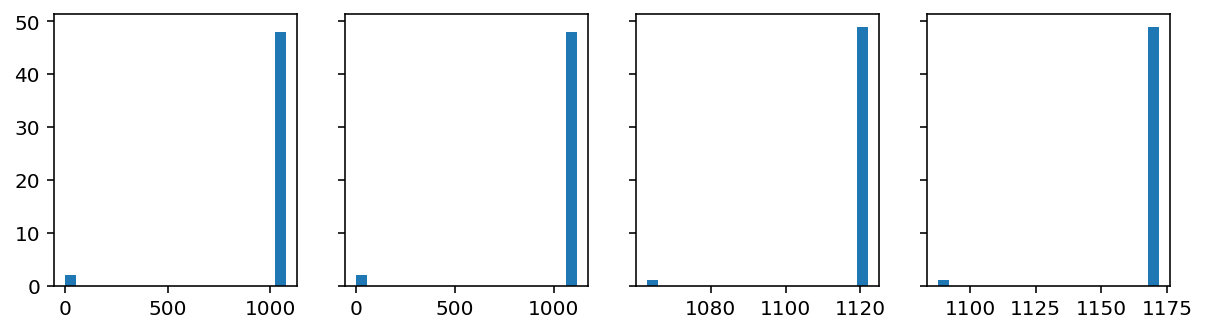

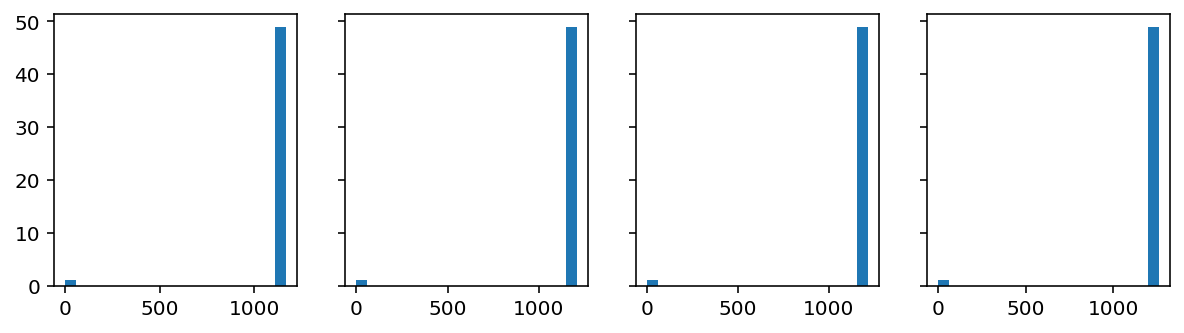

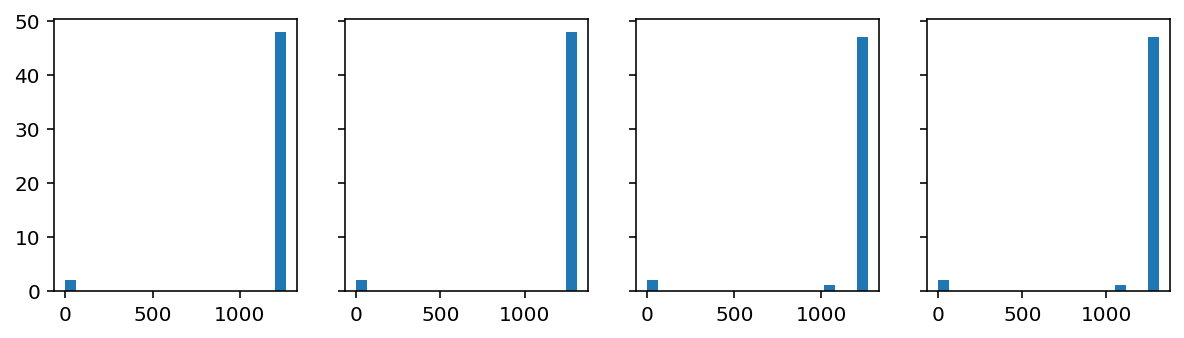

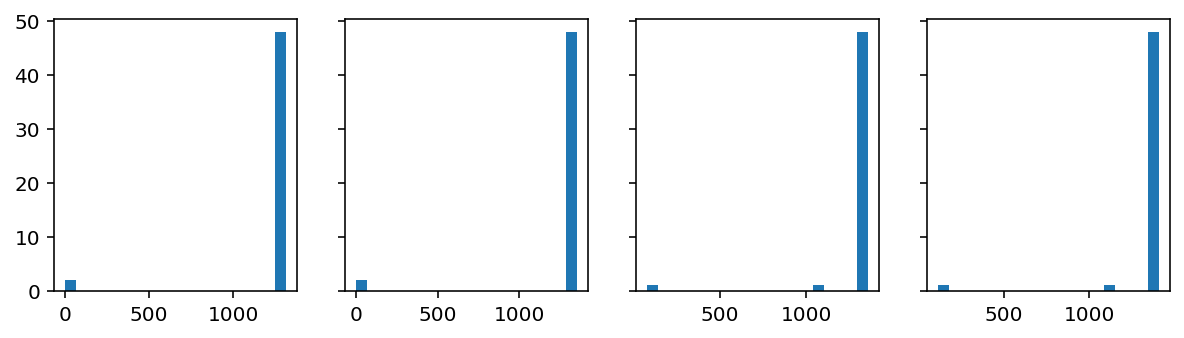

In [138]:
for idx, file in enumerate(digital_files):
    histo4plot(file)